In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import os
import seaborn as sns
import itertools
import csv
from helpers import *
from helper_funcs import *
from plots import *
from implementations import *
from data_preprocessing import *

### Import data

The data should be placed in a folder named `data` within the same repository where the `run.ipynb` file is located. The `data` folder should contain the CSV files: `x_train.csv`, `x_test.csv`, `y_train.csv`, `train_ids.csv`, and `test_ids.csv`.

In [3]:
# Import data
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'data')
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

# Read the header to save the feature labels
data_path = os.path.join(current_directory, 'data')
feature_names = np.genfromtxt(data_path+'/x_train.csv', delimiter=',', max_rows=1, dtype=str)[1:]

The data is saved in a convenient format in a folder named `convenient_data_format` within the same repository where the `run.ipynb` file is located, for ease of access purposes. 

In [5]:
# Saving the generated arrays as .npy files in order to have faster access to it
data_path = os.path.join(current_directory, 'convenient_data_format')

np.save(os.path.join(data_path, 'x_train.npy'), x_train)
np.save(os.path.join(data_path, 'x_test.npy'), x_test)
np.save(os.path.join(data_path, 'y_train.npy'), y_train)
np.save(os.path.join(data_path, 'train_ids.npy'), train_ids)
np.save(os.path.join(data_path, 'test_ids.npy'), test_ids)

In [6]:
# Read the header to save the feature labels
data_path = os.path.join(current_directory, 'data')
feature_names = np.genfromtxt(data_path+'/x_train.csv', delimiter=',', max_rows=1, dtype=str)[1:]

In [7]:
# Loading the arrays saved as .npy files 
data_path = os.path.join(current_directory, 'convenient_data_format')

x_train = np.load(os.path.join(data_path, 'x_train.npy'))
x_test = np.load(os.path.join(data_path, 'x_test.npy'))
y_train = np.load(os.path.join(data_path, 'y_train.npy'))
train_ids = np.load(os.path.join(data_path, 'train_ids.npy'))
test_ids = np.load(os.path.join(data_path, 'test_ids.npy'))

## Data exploration

In [9]:
print('The train and test sets include N_train={} and N_test={} data samples with D={} different features.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[1]))

The train and test sets include N_train=328135 and N_test=109379 data samples with D=321 different features.


### Missing data 

In [11]:
# Determine the features that have at least x % of non-missing data samples  
N_per_feature = x_train.shape[0] - np.sum(np.isnan(x_train), axis = 0)
perc_N_per_feature = N_per_feature / x_train.shape[0]

perc_threshold = [0.7, 0.8, 0.90]
for perc in perc_threshold:
    print('Percentage of features that have at least {} % of non-missing data samples = {} %.'.format(100*perc, 
                                                                                                 100 * np.round(np.sum(perc_N_per_feature >= perc) / len(perc_N_per_feature),4)))

Percentage of features that have at least 70.0 % of non-missing data samples = 44.86 %.
Percentage of features that have at least 80.0 % of non-missing data samples = 44.55 %.
Percentage of features that have at least 90.0 % of non-missing data samples = 43.3 %.


Only features for which at most 10 % of the data is missing are retained. It corresponds to 43.3 % of data. 

In [13]:
# Retain the features for which 90 % of examples are non-missing
features_to_keep_logical = perc_N_per_feature > 0.90
feature_names[features_to_keep_logical]

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
       'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
       'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2',
       'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN',
       'FVORANG', 'VEGETAB1', 'EXERANY2', 'STRENGTH', 'SEATBELT',
       'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTVER', 'QSTLANG', '_STSTR',
       '_STRWT', '_RAWRAKE', '_WT2RAKE', '_DUALUSE', '_LLCPWT', '_RFHLTH',
       '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_CASTHM1',
       '_ASTHMS1', '_DRDXAR1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_

## Data cleaning and preprocessing 
1. **Select features** to keep on the basis of the number of non missing data samples.
2. **Clean** data on the basis of context-specific information - [2015 Codebook Report](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf) for reference. 
3. **Fill missing values** with mode and median respectively for categorical and continuous data.
4. **Drop duplicate columns** to avoid multicollinearity. 
5. **Encode and standardize** respectively categorical and continuous data.

In [15]:
# Select features to keep 
features_to_keep = feature_names[features_to_keep_logical]

### Data Cleaning

Reference function: `data_clean()` in `data_processing.py`.

- The data cleaning process differentiates between binary, categorical, and continuous data types, applying specific manipulation techniques tailored to each category based on guidelines from the _2015 Code Report_ reference manual.
- Features deemed irrelevant for the scope of the study, such as `'IDATE'` (interview date) and `'CELLFON2'` (cellphone use for the interview), are removed, in addition to the features other than the ones defined in `features_to_keep` - on the basis of the relative number of non-missing values.
- Missing values for categorical and continuous data are handled by replacing them with the mode and median of each feature, respectively.

In [17]:
# Clean train and test data sets
x_train, feature_names_clean, categorical_features_idx, continuous_features_idx = clean_data(x_train, feature_names, features_to_keep)
x_test, _, _, _ = clean_data(x_test, feature_names, features_to_keep)
feature_names = feature_names_clean

In [18]:
# Save categorical and continuous features names
categorical_features = feature_names[categorical_features_idx]
continuous_features = feature_names[continuous_features_idx]

# Split the train and test datasets into categorical and continuous 
x_train_cat = x_train[:,categorical_features_idx]
x_train_cont = x_train[:,continuous_features_idx]

x_test_cat = x_test[:,categorical_features_idx]
x_test_cont = x_test[:,continuous_features_idx]

### Data Preprocessing

Reference functions: `preprocess_data()`, `duplicate_columns()`, `feature_selection()` in `data_processing.py`.

- The data preprocessing step involves distinguishing between categorical data - which now includes binary variables, i.e., those with two or more categories - and continuous data types. Categorical data is transformed using **one-hot encoding**, ensuring that the dummy variable trap is avoided, while continuous data is **standardized**. Additionally, a mapping between the feature matrix and feature names is established for both categorical (`feature_cat_map`) and continuous (`feature_cont_map`) features. Furthermore, the encoding process increases the dimension of the dataset by transforming each categorical feature into multiple columns, each corresponding to a unique category. To keep track of this transformation, an additional list called `feature_cat_encoded_map` is created, which maps each column in the encoded categorical feature matrix to its associated unique category.
- Prior to encoding, the dataset is checked for **duplicate columns**. If duplicates are found, - that is there is perfect multicollinearity - they are removed, with careful consideration to retaining the information on the features that explain the same variance in the dataset or that convey the same information, for the interpretation of results.
- Following encoding and standardization, the methodology for **feature selection** differs between categorical and continuous features. For continuous features, **Principal Component Analysis (PCA)** is employed, with a specified number of components to retain as input. Similarly, for categorical features, **Multiple Correspondence Analysis (MCA)** is employed with a specified number of components for selection as input. The selected number of components is roughly half the total number of features, striking a balance between the interpretability of results and the depth of information within the dataset.
- Finally, a column of ones is appended to the feature matrix to incorporate an **offset term**.
- The **target** is converted into a **binary representation**.

In [20]:
# Find indices of unique and duplicate columns
unique_cat_indices, duplicate_indices_grouped = duplicate_columns(x_train_cat)

In [21]:
# Drop duplicate columns from train and test data sets (categorical)
x_train_cat = x_train_cat[:,unique_cat_indices]
x_test_cat = x_test_cat[:,unique_cat_indices]

# Display duplicate columns 
duplicate_cats = []
for dupl_list in duplicate_indices_grouped:
    dupl_idx = np.array(dupl_list).flatten()
    duplicate_cats.append(categorical_features[dupl_idx])

print('The duplicate features are {}'.format(duplicate_cats))

The duplicate features are [array(['EXERANY2', '_TOTINDA'], dtype='<U8'), array(['HIVTST6', '_AIDTST3'], dtype='<U8')]


In [22]:
# Preprocess train and test datasets (encode, standardize and save mapping between feature matrix and feature names)
x_train_cat_encoded, feature_cat_map, feature_cat_encoded_map, x_train_cont_stand, feature_cont_map, x_train_cont_mean, x_train_cont_std = preprocess_data(x_train, feature_names, categorical_features_idx, continuous_features_idx)
x_test_cat_encoded, _, _, x_test_cont_stand, _, x_test_cont_mean, x_test_cont_std = preprocess_data(x_test, feature_names, categorical_features_idx, continuous_features_idx)

In [23]:
# Select features in train dataset
n_comp_cat = int(x_train_cat_encoded.shape[1]*0.5) # number of components to retain for categorical features
n_comp_cont = int(x_train_cont_stand.shape[1]*0.5) # number of components to retain for continuous features
selected_cat_features_idx, selected_cont_features_idx = feature_selection(x_train_cat_encoded, x_train_cont_stand, n_comp_cat, n_comp_cont)

In [24]:
# Keep only selected features in train and test datasets 
x_train_cat_encoded = x_train_cat_encoded[:,selected_cat_features_idx]
x_train_cont_stand = x_train_cont_stand[:,selected_cont_features_idx]

x_test_cat_encoded = x_test_cat_encoded[:,selected_cat_features_idx]
x_test_cont_stand = x_test_cont_stand[:,selected_cont_features_idx]

# Update the mapping between feature matrix and feature names accordingly
feature_cat_map =  feature_cat_map[selected_cat_features_idx] # mapping of categorical features names
feature_cat_encoded_map = feature_cat_encoded_map[selected_cat_features_idx] # mapping of encoded unique categories to features names
feature_cont_map = feature_cont_map[selected_cont_features_idx] # mapping of continuous features 

In [25]:
# Stack the categorical and continuous features to have a unique feature matrix 
x_train_processed = np.hstack([x_train_cat_encoded, x_train_cont_stand])
x_test_processed = np.hstack([x_test_cat_encoded, x_test_cont_stand])

In [26]:
# Transform the target into binary
y_train_processed = np.where(y_train == 1, 1,0).reshape(-1,1)

In [27]:
# Add offset term
y_train, tx_train = build_model_data(y_train_processed, x_train_processed)
tx_test = np.c_[np.ones(x_test_processed.shape[0]), x_test_processed]

Here a visualization of the result of the data cleaning, preprocessing and feature selection is displayed. 

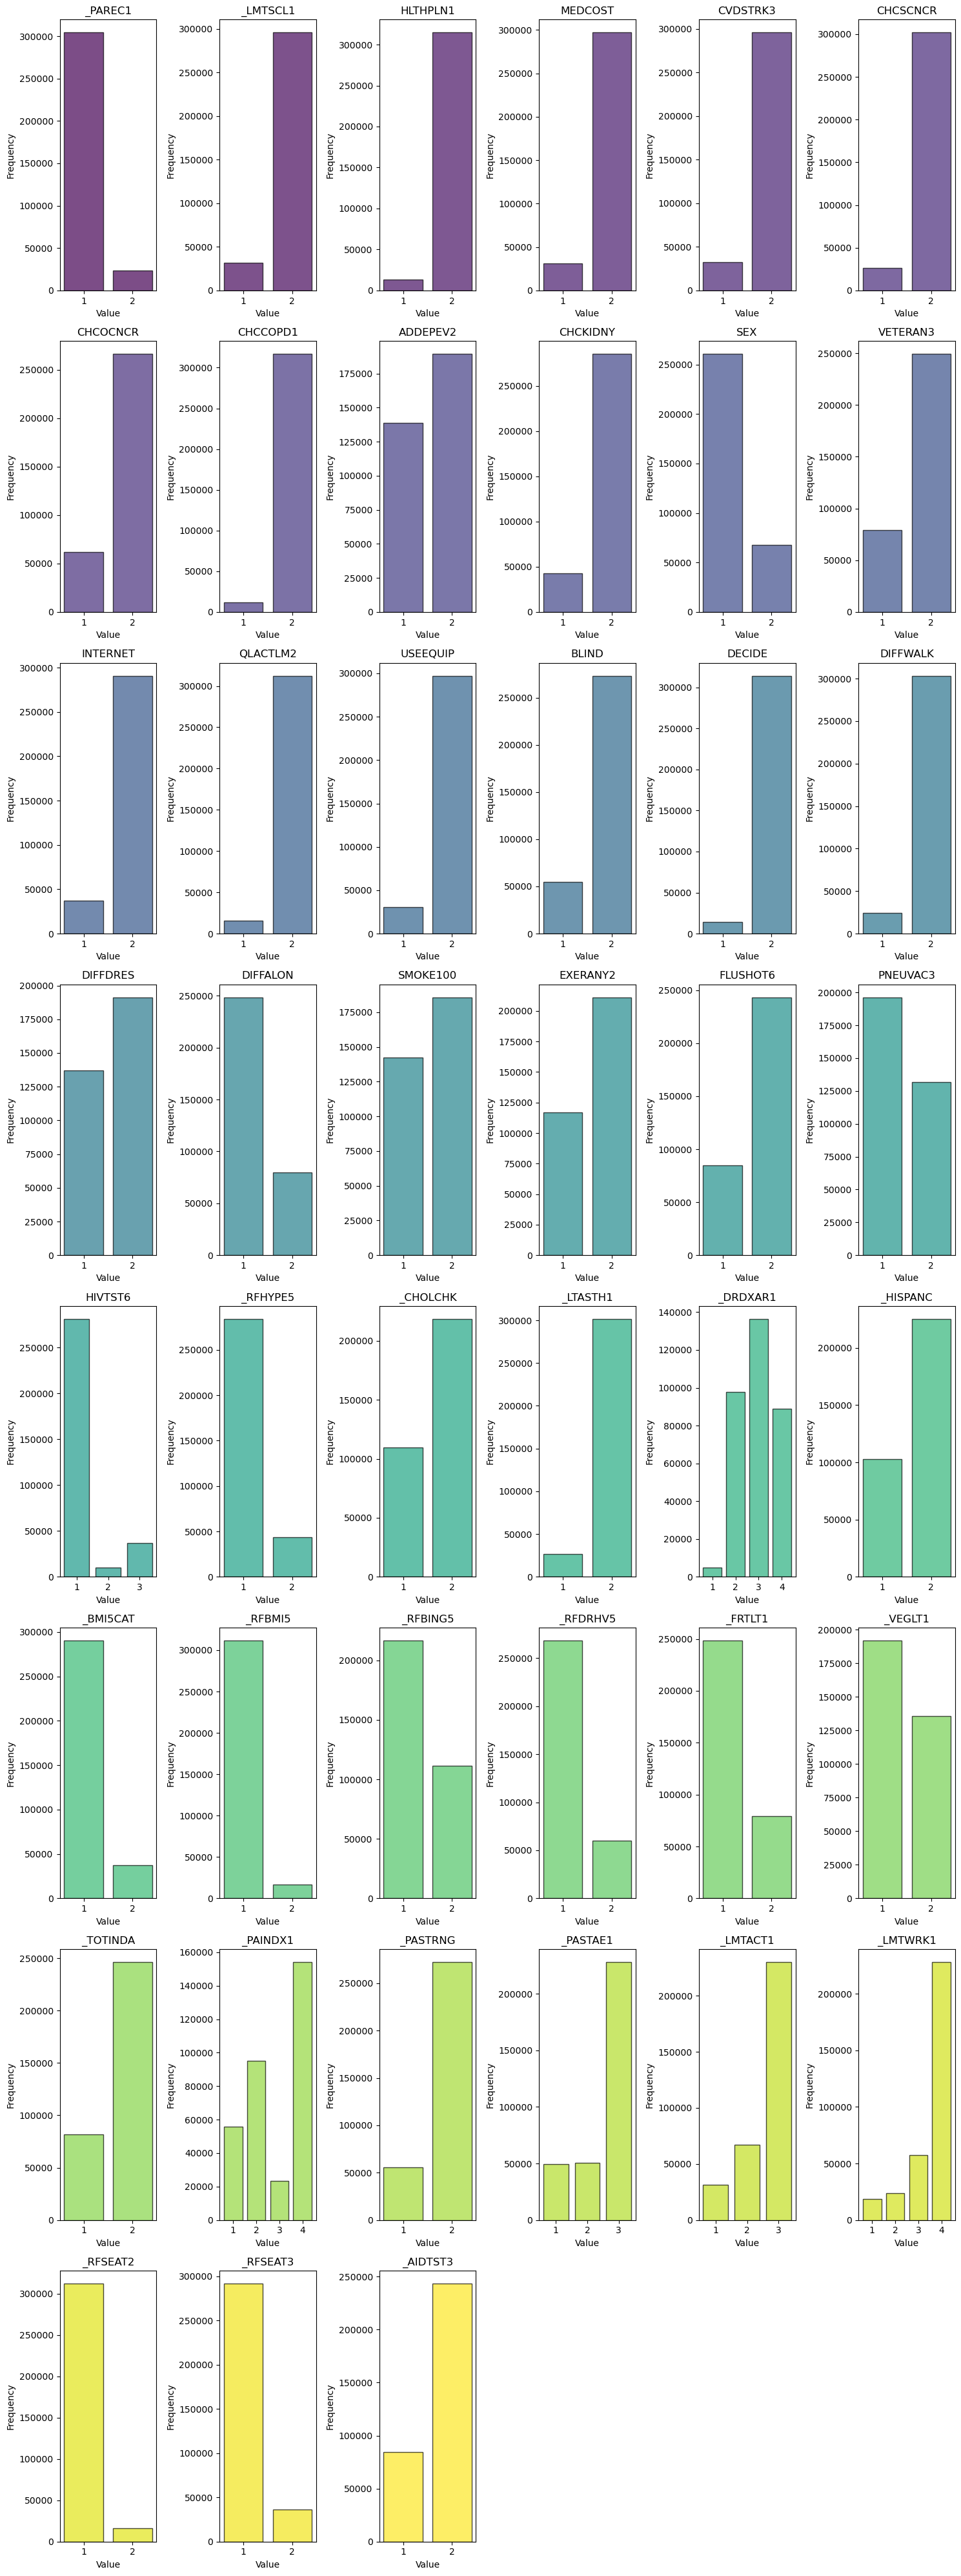

In [29]:
# Visualization of processed and selected categorical features
features_list = [item for item in categorical_features[np.unique(feature_cat_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_histograms(data_list, features_list, num_cols=6)

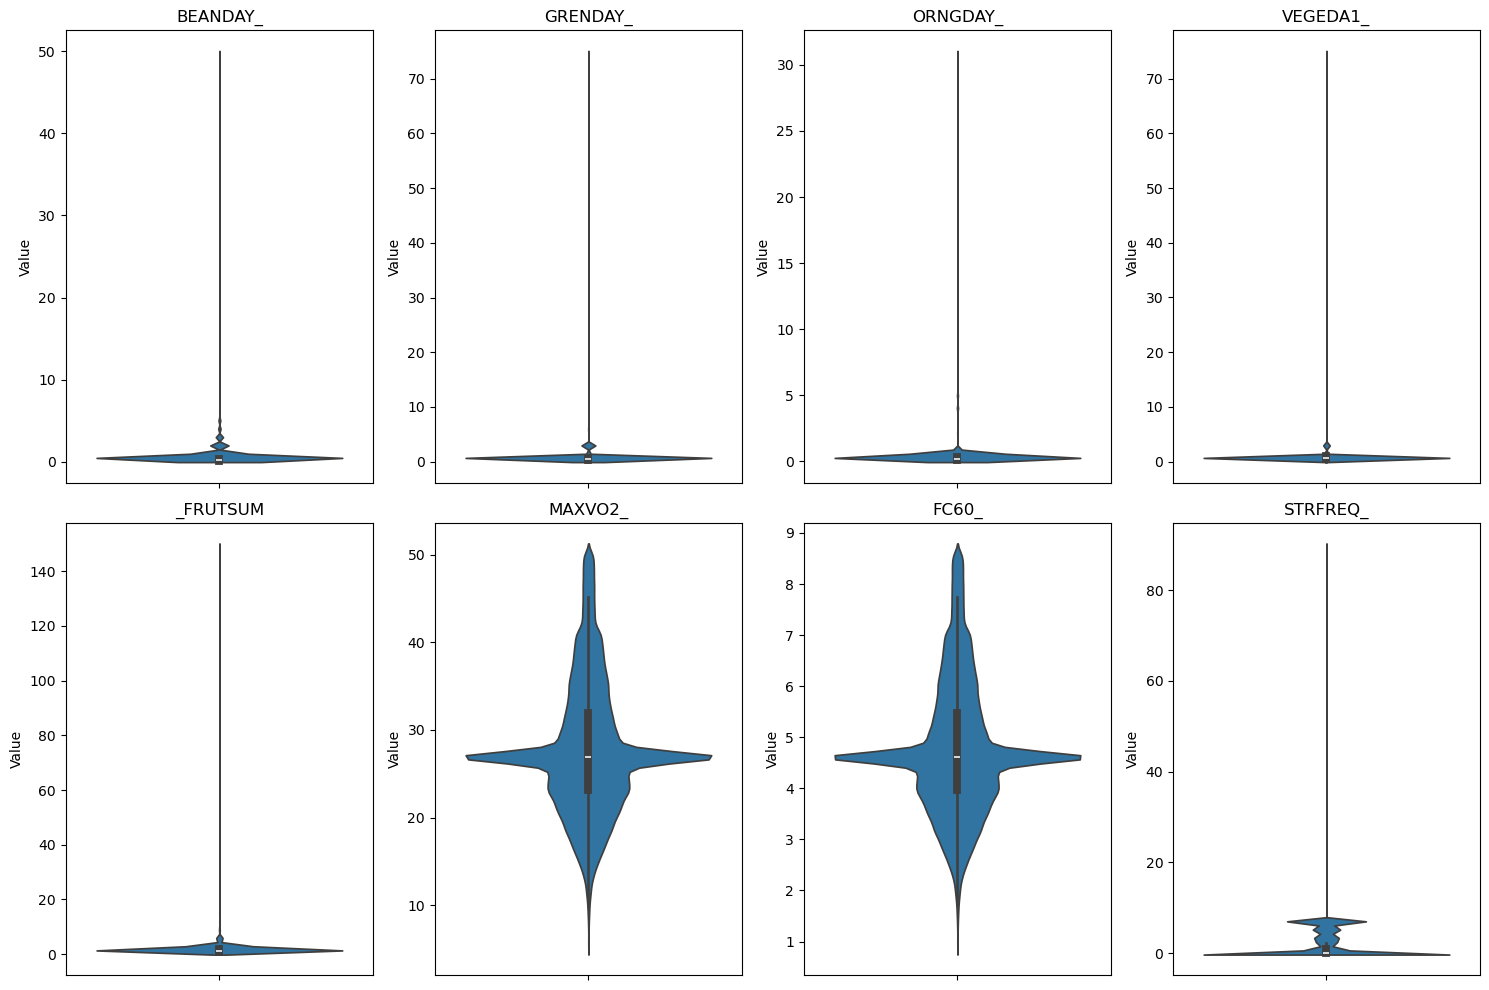

In [30]:
# Visualization of processed and selected continuous features
features_list = [item for item in continuous_features[np.unique(feature_cont_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_violinplots(data_list, features_list, num_cols=4)

## Model selection and validation

1. **Training and Validation sets** for model training and validation.
2. **Balance data** to avoid biased model.
3. **Model validation** with metrics such as F1 score and RMSE.
4. **Hyperparameter tuning** over the learning rate - for iterative algorithms - and penalty - for regularization.

### Train and validation splitting

The dataset is divided into training and validation sets to ensure that the model can learn from one portion of the data while being evaluated on another. The **training set** is used to **fit the model parameters**, allowing the model to learn patterns within the data. The **validation set** is essential for **assessing the model's performance** and generalization capability on unseen data, helping to identify overfitting or underfitting.
- The split ratio is set to 0.8.

In [33]:
# Split data into train and validation sets
np.random.seed(20)

split_index = int(tx_train.shape[0] * 0.8) # index separating train and test set, based on the split ratio = 0.8
indices = np.random.permutation(tx_train.shape[0]) # randomly re-arrange the indeces

# Split the indices for training and validation sets
train_indices = indices[:split_index] 
validation_indices = indices[split_index:]

# Use the indices to split the data
tx_train_training = tx_train[train_indices,:]
tx_train_validation = tx_train[validation_indices,:]
y_train_training = y_train[train_indices]
y_train_validation = y_train[validation_indices]

### Balance Data

Balancing the data is essential to **prevent** the model from becoming **biased toward the majority class**, which can lead to poor performance on the minority class. It ensures that the model has an equal opportunity to learn from all classes, improving its predictive accuracy and robustness.
- The **majority class** is **undersampled** with different balance ratios. This improves generalization and mitigates the risk of overfitting by exposing the model to different class distributions, which can lead to improved performance on unseen data, particularly in situations with imbalanced classes.
- The performance of the model on the balanced dataset is assessed with the **least squares** method and the optimal balance ratio is found by **maximizing the F1 score**.

In [35]:
# Separate features and target minority and majority class
y_majority = y_train_training[y_train_training == 0]
y_minority = y_train_training[y_train_training == 1]
X_majority = tx_train_training[y_train_training.flatten() == 0, :]
X_minority = tx_train_training[y_train_training.flatten() == 1, :]

np.random.seed(21)
split_ratio = [0.2, 0.3, 0.35, 0.4, 0.5]

tx_training_balanced_split = []
y_training_balanced_split = []

for s in split_ratio: # Loop through each defined split ratio
    # Calculate the desired size of the majority class based on the current split ratio
    desired_majority_size = int(len(y_minority) * (1 - s) / s)
    
    # Randomly select `desired_majority_size` samples from the majority class without replacement
    majority_indices = np.random.choice(len(X_majority), desired_majority_size, replace=False)
    X_majority_undersampled = X_majority[majority_indices]
    y_majority_undersampled = y_majority[majority_indices]

    # Combine the full minority class with the undersampled majority class to create a balanced dataset
    tx_training_balanced = np.vstack((X_minority, X_majority_undersampled))
    y_training_balanced = np.hstack((y_minority, y_majority_undersampled)).reshape((-1, 1))

    # Store the balanced data for each split ratio
    tx_training_balanced_split.append(tx_training_balanced)
    y_training_balanced_split.append(y_training_balanced)

In [36]:
# Apply least squares optimization on the balanced datasets to determine the optimal split ratio by maximizing the F1 score

f1_scores = []
for idx, s in enumerate(split_ratio): # Loop through each split ratio

    tx_training_balanced = tx_training_balanced_split[idx] # Select the balanced feature dataset for the current split ratio
    y_training_balanced = y_training_balanced_split[idx] # Select the balanced target vector for the current split ratio
    
    # Apply least squares optimization to the balanced dataset to compute the weights
    _, ls_w = least_squares(y_training_balanced, tx_training_balanced)

    # Predict the target values using the validation set features and the learned weights
    y_pred = tx_train_validation.dot(ls_w)
    # Convert predicted continuous values to binary predictions (0 or 1) using a threshold of 0.5
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Calculate the confusion matrix metrics (true positives, true negatives, false positives, false negatives)
    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    # Calculate the F1 score using the confusion matrix values
    f1_score = 2*tp/(2*tp + fp + fn)
    f1_scores.append(f1_score) # Append the calculated F1 score to the list of F1 scores
    
    print('Least squares - Split ratio {:.2f}/{:.2f} , F1 score = {:.5f}'.format(s, 1-s, f1_score))

# Determine the optimal balanced dataset based on the highest F1 score
tx_training_balanced = tx_training_balanced_split[np.argmax(np.array(f1_scores))]
y_training_balanced = y_training_balanced_split[np.argmax(np.array(f1_scores))]

Least squares - Split ratio 0.20/0.80 , F1 score = 0.33652
Least squares - Split ratio 0.30/0.70 , F1 score = 0.38303
Least squares - Split ratio 0.35/0.65 , F1 score = 0.19180
Least squares - Split ratio 0.40/0.60 , F1 score = 0.35981
Least squares - Split ratio 0.50/0.50 , F1 score = 0.34547


### Model validation

The trained **Machine Learning models** are 
1. Gradient Descent with MSE loss function
2. Stochastic Gradient Descent with MSE loss function
3. Least squares
4. Ridge least squares
5. Logistic regression
6. Regularized logistic regression

- Model validation is performed using metrics such as the **F1 score** and **Root Mean Squared Error (RMSE)** to evaluate the model's performance. The F1 score provides a balance between precision and recall, making it especially useful in cases of imbalanced classes, while RMSE quantifies the average error of the model's predictions in the same units as the target variable. 

- Hyperparameter tuning is performed for finding the optimal hyperparameters such as the **learning rate** — determining the step size during (stochastic) gradient descent — and the **penalty** term for regularization — controlling the complexity of the model. The technique of grid search is utilized to explore the hyperparameter space.
- The best trade-off between bias and variance is assessed for AAAAAA

#### Gradient Descent - MSE loss function

##### Initialisation of the algorithm

In [40]:
# Define the hyperparameters of the algorithm
max_iters = 100
learning_rate = np.linspace(0.01, 0.09, 9)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

# Threshold for classifying the target as either 1 or 0 (binary).
threshold = 0.5 

##### Model training

In [42]:
# Initialize arrays to store F1 scores and RMSE for each learning rate tested
gd_mse_f1_score = np.zeros(len(learning_rate))
gd_mse_rmse = np.zeros(len(learning_rate))

# Lists to store final weights and loss values for each learning rate value
gd_mse_ws_var_gamma = []
gd_mse_losses_var_gamma = []

# Loop over each value in the learning rate parameter array
for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    gd_mse_losses, gd_mse_ws = mean_squared_error_gd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute predictions on the validation set and convert them to binary classes based on the threshold
    y_pred = tx_train_validation.dot(gd_mse_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    # Compute confusion matrix metrics and calculate F1 score and MSE
    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, and performance metrics for analysis
    gd_mse_f1_score[idx] = f1_score
    gd_mse_rmse[idx] = np.sqrt(mse)

    gd_mse_ws_var_gamma.append(gd_mse_ws[-1])
    gd_mse_losses_var_gamma.append(gd_mse_losses)

loss=0.08639893323230936
GD - mse: gamma=0.010, execution time=0.532 seconds 

loss=0.08314251480215679
GD - mse: gamma=0.020, execution time=0.530 seconds 

loss=0.08138991056906644
GD - mse: gamma=0.030, execution time=0.601 seconds 

loss=0.08031139211827197
GD - mse: gamma=0.040, execution time=0.564 seconds 

loss=0.07960242761550529
GD - mse: gamma=0.050, execution time=0.585 seconds 

loss=0.07910933098827999
GD - mse: gamma=0.060, execution time=0.605 seconds 

loss=0.07874788524187377
GD - mse: gamma=0.070, execution time=0.634 seconds 

loss=0.07846964517149037
GD - mse: gamma=0.080, execution time=0.703 seconds 

loss=0.07824580517684188
GD - mse: gamma=0.090, execution time=0.583 seconds 



##### Model evaluation

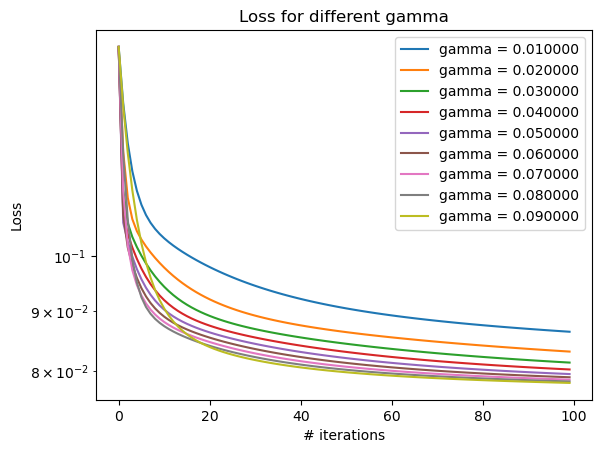

In [44]:
# Plot loss as a function of the number of iterations, for variable learning rate
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

Comments: 
- The loss descreases with the number of iterations.
- The loss descreases faster with larger learning rate.

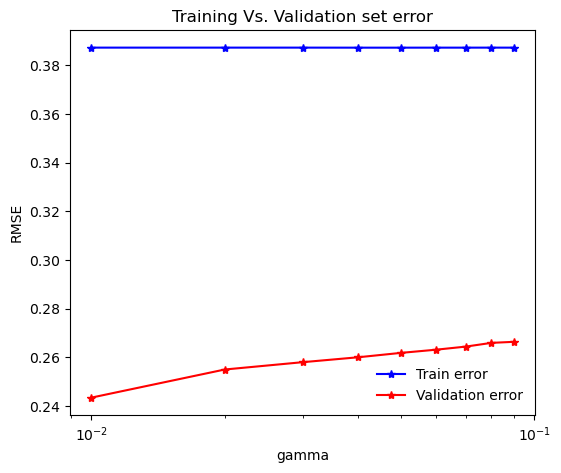

In [46]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

rmse_validation = gd_mse_rmse
rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, gd_mse_ws_var_gamma, learning_rate, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, learning_rate, 'gamma')

Comments:
- The validation error is smaller than the train error, for all learning rates. This might be due to a small validation set (much smaller than the training set, i.e. 20 % of the original data samples) as it may not represent the full data distribution. Further, since the MSE loss function is non-robust, if the training data includes noise or outliers, the model may fit this noise, resulting in a higher training error.

In [48]:
# Get optimal hyperparameter and corresponding model weights, apply to test set
metrics = np.hstack([gd_mse_f1_score.reshape(-1,1), gd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score' # maximize F1 score

gd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, gd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.090000 given optimization of the metric f1_score evaluating 0.35144.

*******************************

---------------- True Vs. Predicted positive class (Heart Attack Rate) ---------------- 

Train set (balanced):
True 0.300, Predicted 0.204.
Validation set:
True 0.087, Predicted 0.131.
Test set:
Predicted 0.129.


Comments:
- The F1 score falls below commonly accepted benchmarks for a good fit.
- The predicted positive class rate for the training set slightly underestimates the true, whereas the predicted positive class rate for the the validation set slightly overestimates the true.

In [50]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(gd_mse_ws_var_gamma[gd_mse_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10, 1)
print('The categorical and continuous features with higher weights are respectively \n{} - categories {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['_BMI5CAT' '_PASTRNG' 'DIFFDRES' '_PASTAE1' '_LTASTH1' '_RFBMI5'
 '_BMI5CAT' '_HISPANC' 'INTERNET' '_RFHYPE5'] - categories [4 2 2 2 2 2 2 2 2 2] 
and 
['STRFREQ_'].
The correspondend weights are respectively 
[0.03281882 0.03630058 0.03753017 0.04623832 0.05072095 0.05125476
 0.05181441 0.07170418 0.07667404 0.16233851]
and 
[0.02025752].


Comments: 

#### Stochastic gradient descent - MSE loss function

##### Initialisation of the algorithm 

In [54]:
# Define the hyperparameters of the algorithm
max_iters = 100
learning_rate = np.linspace(0.001, 0.1, 10)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

# Threshold for classifying the target as either 1 or 0 (binary).
threshold = 0.5 

##### Model training

In [56]:
# Initialize arrays to store F1 scores and RMSE for each learning rate tested
sgd_mse_f1_score = np.zeros(len(learning_rate))
sgd_mse_rmse = np.zeros(len(learning_rate))

# Lists to store final weights and loss values for each learning rate value
sgd_mse_ws_var_gamma = []
sgd_mse_losses_var_gamma = []

# Loop over each value in the learning rate parameter array
for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    losses, ws = mean_squared_error_sgd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("SGD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute predictions on the validation set and convert them to binary classes based on the threshold
    y_pred = tx_train_validation.dot(ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    # Compute confusion matrix metrics and calculate F1 score and MSE
    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, and performance metrics for analysis
    sgd_mse_f1_score[idx] = f1_score
    sgd_mse_rmse[idx] = np.sqrt(mse)

    sgd_mse_ws_var_gamma.append(ws[-1])
    sgd_mse_losses_var_gamma.append(losses)
    

loss=0.03770347811196907
SGD - mse: gamma=0.001, execution time=0.010 seconds 

loss=0.1416998744522235
SGD - mse: gamma=0.012, execution time=0.002 seconds 

loss=0.1686444595983617
SGD - mse: gamma=0.023, execution time=0.002 seconds 

loss=0.26633385136848187
SGD - mse: gamma=0.034, execution time=0.009 seconds 

loss=0.2354179727195396
SGD - mse: gamma=0.045, execution time=0.003 seconds 

loss=0.016704563016289305
SGD - mse: gamma=0.056, execution time=0.010 seconds 

loss=0.06817442729662215
SGD - mse: gamma=0.067, execution time=0.009 seconds 

loss=0.38645726453700424
SGD - mse: gamma=0.078, execution time=0.008 seconds 

loss=0.6608977201588884
SGD - mse: gamma=0.089, execution time=0.008 seconds 

loss=295083.7252228182
SGD - mse: gamma=0.100, execution time=0.004 seconds 



##### Model evaluation

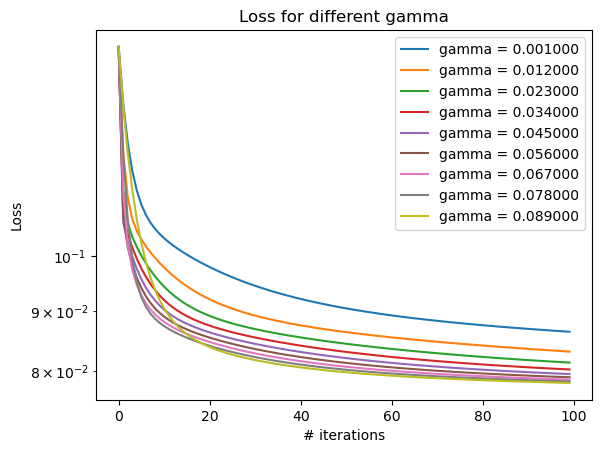

In [58]:
# Plot loss as a function of the number of iterations, for variable learning rate
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

Comments: 
- The loss descreases with the number of iterations.
- The loss descreases faster with larger learning rate.

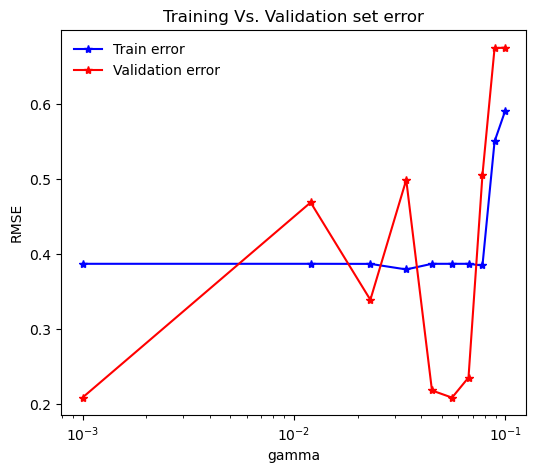

In [60]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

rmse_validation = sgd_mse_rmse
rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, sgd_mse_ws_var_gamma, learning_rate, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, learning_rate, 'gamma')

Comments:
- The training and validation errors are similar across all learning rates.
- The validation error shows greater fluctuations compared to the training error, nevertheless also the training error widely oscillates. As a matter of fact in SGD, each iteration updates weights based on a single or small batch of samples, which introduces noise in the gradient. A larger $\gamma$ amplifies this noise, leading to more volatile updates. This can cause the validation error to fluctuate widely because the model's parameters are constantly moving around the optimal point rather than converging smoothly.

In [62]:
# Get optimal hyperparameter and corresponding model weights, apply to test set
metrics = np.hstack([sgd_mse_f1_score.reshape(-1,1), sgd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score' # maximize F1 score

sgd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, sgd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.023000 given optimization of the metric f1_score evaluating 0.31878.

*******************************

---------------- True Vs. Predicted positive class (Heart Attack Rate) ---------------- 

Train set (balanced):
True 0.300, Predicted 0.338.
Validation set:
True 0.087, Predicted 0.251.
Test set:
Predicted 0.256.


Comments:
- The F1 score falls below commonly accepted benchmarks for a good fit.
- The predicted positive class rate for the training set slightly underestimates the true, whereas the predicted positive class rate for the the validation set slightly overestimates the true.

In [64]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(sgd_mse_ws_var_gamma[sgd_mse_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10, 1)
print('The categorical and continuous features with higher weights are respectively \n{} - categories {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['CHCSCNCR' 'CHCOCNCR' '_PASTRNG' '_LTASTH1' '_PASTAE1' '_BMI5CAT'
 '_RFBMI5' 'INTERNET' '_HISPANC' '_RFHYPE5'] - categories [2 2 2 2 2 4 2 2 2 2] 
and 
['STRFREQ_'].
The correspondend weights are respectively 
[0.02802853 0.0308023  0.03101101 0.03138294 0.0373168  0.04034943
 0.04580176 0.04805954 0.05509096 0.10902596]
and 
[0.01199503].


Comments:

In [224]:
tx = tx_training_balanced
y = y_training_balanced

def compute_mse(y, tx, w):
    """compute the loss by mse.
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        w: weights, numpy array of shape(D,), D is the number of features.

    Returns:
        mse: scalar corresponding to the mse with factor (1 / 2 n) in front of the sum

    >>> compute_mse(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), np.array([0.03947092, 0.00319628]))
    0.006417022764962313
    """

    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
    """
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, param):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)
    """

    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # form data with polynomial degree
    tx_tr = x_tr
    tx_te = x_te
    # ridge regression
    _, ws = mean_squared_error_sgd(y, tx, w_initial, max_iters, param)
    w = ws[-1]
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te

def cross_validation_visualization(params, rmse_tr, rmse_te):
    """visualization the curves of rmse_tr and rmse_te."""
    plt.semilogx(lambds, rmse_tr, marker=".", color="b", label="train error")
    plt.semilogx(lambds, rmse_te, marker=".", color="r", label="test error")
    plt.xlabel("lambda")
    plt.ylabel("r mse")
    # plt.xlim(1e-4, 1)
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

    
def cross_validation_demo(k_fold, params):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    k_fold = k_fold
    params = params
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for param in params:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, param)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    best_param, best_rmse = params[np.argmin(rmse_te)], np.min(rmse_te)

    cross_validation_visualization(params, rmse_tr, rmse_te)
    print(
        "The choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f"
        % (best_param, best_rmse)
    )
    return best_param, best_rmse

In [226]:
best_lambda, best_rmse = cross_validation_demo(4, np.logspace(-4, 0, 3))

loss=0.001743058469578991


ValueError: shapes (58107,1) and (58107,1) not aligned: 1 (dim 1) != 58107 (dim 0)

#### Least squares

##### Model training

In [68]:
# Execute optimization algorithm, save losses and weights 
start_time = datetime.datetime.now()
ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)
end_time = datetime.datetime.now()

# Print execution time 
execution_time = (end_time - start_time).total_seconds()
print("Least squares: execution time={t:.3f} seconds.\n\n".format(t=execution_time))

# Compute predictions on the validation set and convert them to binary classes based on the threshold
y_pred = tx_train_validation.dot(ls_w)
y_pred = np.where(y_pred > threshold, 1, 0)

# Compute confusion matrix metrics and calculate F1 score and MSE
tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
f1_score = 2*tp/(2*tp + fp + fn)
rmse = np.sqrt(calculate_mse(y_train_validation - y_pred))

Least squares: execution time=0.023 seconds.




##### Model evaluation

In [70]:
# Display optimal model weights, apply to test set
# print('The optimal weights are w = {}.\n'.format(ls_w))
print('f1 score = {f:.5f}, RMSE = {r:.5f}\n'.format(f=f1_score, r=rmse))
print('*******************************\n')
print_report(ls_w, False, tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test)

The optimal weights are w = [[ 1.11642508e+00]
 [ 6.43646846e-02]
 [ 2.52762506e-02]
 [-8.78843395e-04]
 [-1.73353671e-02]
 [ 6.34425328e-02]
 [-2.57119950e-03]
 [-2.68641037e-02]
 [-2.27877796e-01]
 [-2.90589836e-02]
 [-1.91373798e-02]
 [-1.37727534e-01]
 [-1.69991879e-02]
 [-1.28297636e-01]
 [-1.15325833e-01]
 [-3.81862749e-02]
 [ 4.55805478e-02]
 [-4.94379298e-02]
 [-3.78691754e-02]
 [-4.79206298e-02]
 [-2.37037734e-02]
 [-6.07812129e-02]
 [ 1.35065986e-02]
 [-1.01737528e-02]
 [-4.01028532e-02]
 [ 9.27683862e+00]
 [-2.69101187e-04]
 [-7.37226306e-02]
 [ 1.24075515e+11]
 [ 1.28772985e-01]
 [-6.42058031e-02]
 [-4.11094647e-02]
 [ 7.19519117e-03]
 [-6.95118281e-02]
 [-1.94135263e-02]
 [-6.42216273e-03]
 [ 1.13966484e+11]
 [ 1.13966484e+11]
 [-1.13966484e+11]
 [-3.68552672e-02]
 [-2.51064942e-02]
 [ 2.04157551e-03]
 [-4.15225374e-03]
 [-9.27093706e+00]
 [-2.58927897e-02]
 [ 4.34249196e-02]
 [-3.69433638e-02]
 [ 1.47194138e-02]
 [-2.43385888e-02]
 [-3.81063243e-03]
 [-7.74815830e-03]
 [ 

Comments:
- The F1 score falls below commonly accepted benchmarks for a good fit.
- The predicted positive class rate for the training set slightly underestimates the true, whereas the predicted positive class rate for the the validation set slightly overestimates the true.

In [72]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(ls_w.flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10,1)
print('The categorical and continuous features with higher weights are respectively \n{} - categories {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))


The categorical and continuous features with higher weights are respectively 
['_PAREC1' '_PASTRNG' 'INTERNET' '_LMTSCL1' '_PAREC1' '_RFHYPE5'
 'EXERANY2' '_BMI5CAT' '_BMI5CAT' 'HIVTST6'] - categories [4 2 2 4 3 2 2 3 4 2] 
and 
['FC60_'].
The correspondend weights are respectively 
[2.52762506e-02 4.34249196e-02 4.55805478e-02 6.34425328e-02
 6.43646846e-02 1.28772985e-01 9.27683862e+00 1.13966484e+11
 1.13966484e+11 1.24075515e+11]
and 
[8.71674397].


Comments:

#### Ridge regression

##### Initialisation of the algorithm 

In [76]:
# Define the hyperparameters of the algorithm
max_iters = 100
penalty = np.logspace(-4, 0, 5)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

# Threshold for classifying the target as either 1 or 0 (binary).
threshold = 0.5 

In [77]:
# Initialize arrays to store F1 scores and RMSE for each penalty tested
ridge_ls_f1_score = np.zeros(len(penalty))
ridge_ls_rmse = np.zeros(len(penalty))

# Lists to store final weights and loss values for each penalty value
ridge_ls_loss = np.zeros(len(penalty))
ridge_ls_ws_var_lambda = []

# Loop over each value in the penalty parameter array
for idx, lambda_ in enumerate(penalty):

    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    ridge_ls_losses, ridge_ls_ws = ridge_regression(y_training_balanced, tx_training_balanced, lambda_)
    end_time = datetime.datetime.now()

    # Print execution time 
    execution_time = (end_time - start_time).total_seconds()
    print("Ridge regression: lambda={l:.3f}, execution time={t:.3f} seconds \n".format(l=lambda_, t=execution_time))

    # Compute predictions on the validation set and convert them to binary classes based on the threshold
    y_pred = tx_train_validation.dot(ridge_ls_ws)
    y_pred = np.where(y_pred > threshold, 1, 0)

    # Compute confusion matrix metrics and calculate F1 score and MSE
    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, and performance metrics for analysis
    ridge_ls_f1_score[idx] = f1_score
    ridge_ls_rmse[idx] = np.sqrt(mse)

    ridge_ls_loss[idx] = ridge_ls_losses
    ridge_ls_ws_var_lambda.append(ridge_ls_ws)

Ridge regression: lambda=0.000, execution time=0.026 seconds 

Ridge regression: lambda=0.001, execution time=0.029 seconds 

Ridge regression: lambda=0.010, execution time=0.032 seconds 

Ridge regression: lambda=0.100, execution time=0.030 seconds 

Ridge regression: lambda=1.000, execution time=0.022 seconds 



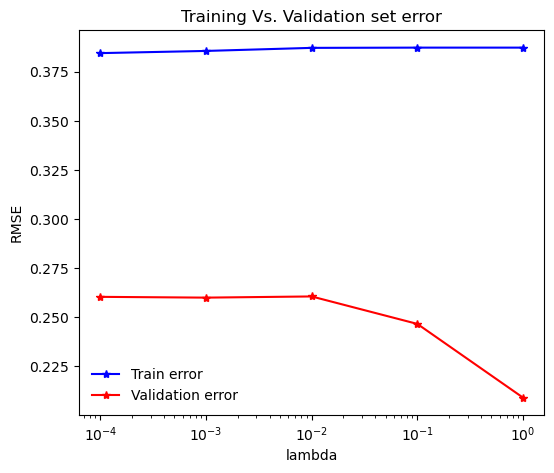

In [78]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

rmse_validation = ridge_ls_rmse
rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, ridge_ls_ws_var_lambda, penalty, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, penalty, 'lambda')

See the comments for gradient descent method. 

In [80]:
# Get optimal hyperparameter and corresponding model weights, apply to test set
metrics = np.hstack([ridge_ls_f1_score.reshape(-1,1), ridge_ls_rmse.reshape(-1,1)])
metric_name = 'f1_score' # maximize F1

ridge_ls_opt_idx = hyperparam_optimization(metric_name, metrics, ridge_ls_ws_var_lambda, penalty, 'lambda', tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is lambda=0.000100 given optimization of the metric f1_score evaluating 0.38154.

*******************************

---------------- True Vs. Predicted positive class (Heart Attack Rate) ---------------- 

Train set (balanced):
True 0.300, Predicted 0.214.
Validation set:
True 0.087, Predicted 0.132.
Test set:
Predicted 0.131.


In [81]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(ridge_ls_ws_var_lambda[ridge_ls_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10, 1)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['_RFSEAT3' '_LMTACT1' 'DIFFDRES' '_RFSEAT2' '_PAREC1' '_PASTRNG'
 'INTERNET' '_PAREC1' '_LMTSCL1' '_RFHYPE5'] - columns [2 2 2 2 4 2 2 3 4 2] 
and 
['BEANDAY_'].
The correspondend weights are respectively 
[0.00988506 0.01313841 0.01608217 0.01663008 0.02335233 0.0426782
 0.0467043  0.05744497 0.06659062 0.12986111]
and 
[0.00299758].


Comments:

In [214]:
x = tx_training_balanced
y = y_training_balanced.flatten()

def compute_mse(y, tx, w):
    """compute the loss by mse.
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        w: weights, numpy array of shape(D,), D is the number of features.

    Returns:
        mse: scalar corresponding to the mse with factor (1 / 2 n) in front of the sum

    >>> compute_mse(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), np.array([0.03947092, 0.00319628]))
    0.006417022764962313
    """

    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
    """
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)
    """

    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # form data with polynomial degree
    tx_tr = x_tr
    tx_te = x_te
    # ridge regression
    w = ridge_regression(y_tr, tx_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te

def cross_validation_visualization(lambds, rmse_tr, rmse_te):
    """visualization the curves of rmse_tr and rmse_te."""
    plt.semilogx(lambds, rmse_tr, marker=".", color="b", label="train error")
    plt.semilogx(lambds, rmse_te, marker=".", color="r", label="test error")
    plt.xlabel("lambda")
    plt.ylabel("r mse")
    # plt.xlim(1e-4, 1)
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

    
def cross_validation_demo(k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    best_lambda, best_rmse = lambdas[np.argmin(rmse_te)], np.min(rmse_te)

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    print(
        "The choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f"
        % (best_lambda, best_rmse)
    )
    return best_lambda, best_rmse

The choice of lambda which leads to the best test rmse is 0.00010 with a test rmse of 0.385


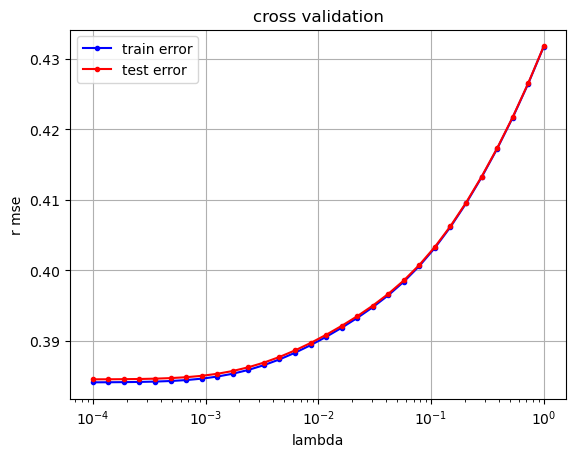

In [216]:
best_lambda, best_rmse = cross_validation_demo(4, np.logspace(-4, 0, 30))

#### Logistic regression

##### Initialization of the algorithm

In [85]:
# Define the hyperparameters of the algorithm
max_iters = 100
learning_rate = np.logspace(-4, -1, 4)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

# Threshold for classifying the target as either 1 or 0 (binary).
threshold = 0

##### Model training

In [87]:
# Initialize arrays to store F1 scores and RMSE for each learning rate tested
logistic_gd_f1_score = np.zeros(len(learning_rate))
logistic_gd_rmse = np.zeros(len(learning_rate))

# Lists to store final weights and loss values for each learning rate value
logistic_gd_ws_var_gamma = []
logistic_gd_losses_var_gamma = []

# Loop over each value in the learning rate parameter array
for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    logistic_gd_losses, logistic_gd_ws = logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("Logistic regression - Gradient descent: gamma={g:.4f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute predictions on the validation set and convert them to binary classes based on the threshold
    y_pred = tx_train_validation.dot(logistic_gd_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    # Compute confusion matrix metrics and calculate F1 score and MSE
    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, and performance metrics for analysis
    logistic_gd_f1_score[idx] = f1_score
    logistic_gd_rmse[idx] = np.sqrt(mse)

    logistic_gd_ws_var_gamma.append(logistic_gd_ws[-1])
    logistic_gd_losses_var_gamma.append(logistic_gd_losses)

loss=0.6830352089032806
Logistic regression - Gradient descent: gamma=0.0001, execution time=1.011 seconds 

loss=0.6242943016033959
Logistic regression - Gradient descent: gamma=0.0010, execution time=0.827 seconds 

loss=0.5411642492719277
Logistic regression - Gradient descent: gamma=0.0100, execution time=0.800 seconds 

loss=0.4733696859528465
Logistic regression - Gradient descent: gamma=0.1000, execution time=0.808 seconds 



##### Model evaluation

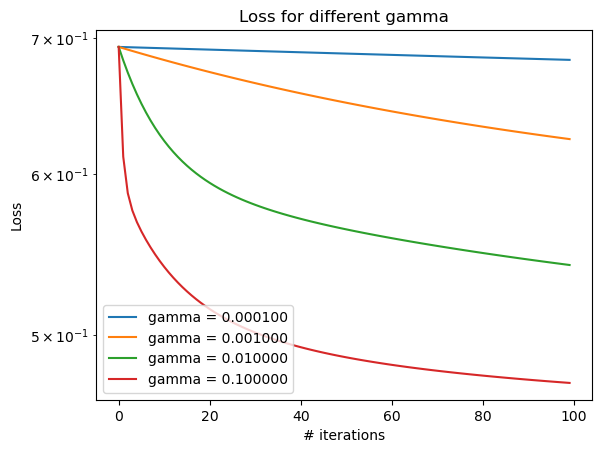

In [89]:
# Plot loss as a function of the number of iterations, for variable learning rate
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

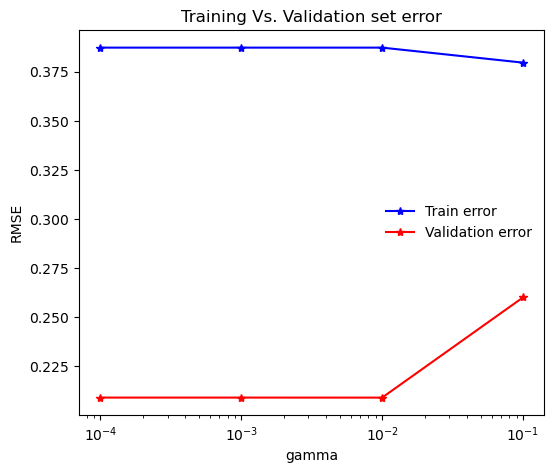

In [90]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

rmse_validation = logistic_gd_rmse
rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, logistic_gd_ws_var_gamma, learning_rate, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, learning_rate, 'gamma')

In [91]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([logistic_gd_f1_score.reshape(-1,1), logistic_gd_rmse.reshape(-1,1)])
metric_name = 'f1_score'

logistic_gd_opt_idx = hyperparam_optimization(metric_name, metrics, logistic_gd_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test, True)

The optimal parameter is gamma=0.100000 given optimization of the metric f1_score evaluating 0.33448.

*******************************

---------------- True Vs. Predicted positive class (Heart Attack Rate) ---------------- 

Train set (balanced):
True 0.300, Predicted 0.183.
Validation set:
True 0.087, Predicted 0.116.
Test set:
Predicted 0.110.


In [92]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(logistic_gd_ws_var_gamma[logistic_gd_opt_idx].flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10,1)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['HIVTST6' '_PASTAE1' 'EXERANY2' '_TOTINDA' '_PAREC1' '_LTASTH1'
 '_BMI5CAT' '_RFBMI5' 'INTERNET' '_RFHYPE5'] - columns [2 2 2 2 4 2 4 2 2 2] 
and 
['BEANDAY_'].
The correspondend weights are respectively 
[0.04860203 0.04975418 0.05260389 0.05260389 0.05472026 0.07239285
 0.08704428 0.08792177 0.1645906  0.38780549]
and 
[0.00349597].


#### Regularized Logistic Regression 

##### Initialization of the algorithm

In [95]:
# Define the hyperparameters of the algorithm
max_iters = 100
learning_rate = np.logspace(-4, -1, 4)
penalty = np.logspace(-6, 0, 7)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))

# Threshold for classifying the target as either 1 or 0 (binary).
threshold = 0

##### Model training

In [97]:
# Initialize arrays to store F1 scores and RMSE for each learning rate tested
reg_lr_f1_score = np.zeros((len(penalty), len(learning_rate)))
reg_lr_rmse = np.zeros((len(penalty), len(learning_rate)))

# Lists to store final weights and loss values for each learning rate and penalty value
reg_lr_ws_var_lambda_and_gamma = []
reg_lr_losses_var_lambda_and_gamma = []

# Loop over each value in the penalty parameter array
for idx_l, lambda_ in enumerate(penalty):

    # Loop over each value in the learning rate parameter array
    for idx_g, gamma in enumerate(learning_rate):
    
        # Execute optimization algorithm, save losses and weights at every iteration
        start_time = datetime.datetime.now()
        reg_logistic_losses, reg_logistic_ws = reg_logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma, lambda_)
        end_time = datetime.datetime.now()
        
        # Print excecution time
        execution_time = (end_time - start_time).total_seconds()
        print("Regularized logistic regression: gamma={g:.4f}, lambda={l:.6f}, execution time={t:.3f} seconds \n".format(g=gamma, l= lambda_, t=execution_time))
    
        # Compute predictions on the validation set and convert them to binary classes based on the threshold
        y_pred = tx_train_validation.dot(reg_logistic_ws[-1])
        y_pred = np.where(y_pred > threshold, 1, 0)

        # Compute confusion matrix metrics and calculate F1 score and MSE
        tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
        f1_score = 2*tp/(2*tp + fp + fn)
        mse = calculate_mse(y_train_validation - y_pred)
        
        # Save losses, weights, and performance metrics for analysis
        reg_lr_f1_score[idx_l, idx_g] = f1_score
        reg_lr_rmse[idx_l, idx_g] = np.sqrt(mse)
    
        reg_lr_ws_var_lambda_and_gamma.append(reg_logistic_ws[-1].flatten())
        reg_lr_losses_var_lambda_and_gamma.append(reg_logistic_losses)
        
reg_lr_ws_var_lambda_and_gamma = np.reshape(reg_lr_ws_var_lambda_and_gamma, (len(penalty), len(learning_rate), len(w_initial)))
reg_lr_losses_var_lambda_and_gamma = np.reshape(reg_lr_losses_var_lambda_and_gamma, (len(penalty), len(learning_rate), max_iters))

loss=0.68303520909936
Regularized logistic regression: gamma=0.0001, lambda=0.000001, execution time=1.013 seconds 

loss=0.6242943131667069
Regularized logistic regression: gamma=0.0010, lambda=0.000001, execution time=1.033 seconds 

loss=0.5411643865747374
Regularized logistic regression: gamma=0.0100, lambda=0.000001, execution time=0.884 seconds 

loss=0.47337080408896726
Regularized logistic regression: gamma=0.1000, lambda=0.000001, execution time=0.902 seconds 

loss=0.6830352108640995
Regularized logistic regression: gamma=0.0001, lambda=0.000010, execution time=0.742 seconds 

loss=0.6242944172364159
Regularized logistic regression: gamma=0.0010, lambda=0.000010, execution time=0.714 seconds 

loss=0.5411656222872149
Regularized logistic regression: gamma=0.0100, lambda=0.000010, execution time=0.850 seconds 

loss=0.4733808663446499
Regularized logistic regression: gamma=0.1000, lambda=0.000010, execution time=0.895 seconds 

loss=0.6830352285114557
Regularized logistic regr

##### Model evaluation

In [99]:
# Get optimal hyperparameter and corresponding model weights, apply to test set

# Set the metric to evaluate for optimal hyperparameters
metric_name = 'f1_score'
# Based on the chosen metric, select the corresponding array and determine the optimal index
if metric_name == 'f1_score':
    metric = reg_lr_f1_score
    opt_index = np.argmax(reg_lr_f1_score)
elif metric_name == 'RMSE':
    metric = reg_lr_rmse
    opt_index = np.argmin(reg_lr_rmse)

# Convert the 1D optimal index to 2D row and column indices for hyperparameters
opt_row, opt_col = np.unravel_index(opt_index, metric.shape)

# Retrieve the optimal values for the hyperparameters (lambda and gamma) and the corresponding weights
opt_lambda = penalty[opt_row]
opt_gamma = learning_rate[opt_col]
opt_w = reg_lr_ws_var_lambda_and_gamma[opt_row, opt_col]
opt_metric = metric[opt_row, opt_col]

# Print the optimal parameters and the corresponding metric value
print('The optimal parameters are lambda ={l:.6f} and gamma = {g:.6f} given optimization of the metric {metr} evaluating {m:.5f}.\n'.format(l = opt_lambda, g=opt_gamma, metr=metric_name, m=opt_metric))
print('The optimal weights are w = {}.\n'.format(opt_w))
print('*******************************\n')

# Call a function to print the report based on the optimal weights and training data
print_report(opt_w, True, tx_training_balanced, y_training_balanced, tx_train_validation, y_train_validation, tx_test)

The optimal parameters are lambda =0.000100 and gamma = 0.100000 given optimization of the metric f1_score evaluating 0.33466.

The optimal weights are w = [ 0.0313783   0.00306802  0.05467148  0.03772932 -0.00836402 -0.07952456
 -0.01593789 -0.01653274 -0.16385165 -0.03914502 -0.04001461 -0.1767568
 -0.0693744  -0.0773486  -0.21389715 -0.11270558  0.16446049 -0.21634549
 -0.14737679 -0.0526626  -0.07630584 -0.20546158 -0.0389533  -0.07891706
 -0.16993775  0.05257281 -0.03647166 -0.20434387  0.04855162  0.38746175
 -0.02435896 -0.07938234  0.07232443 -0.12212645  0.03824777 -0.05667093
  0.00086329  0.08696374  0.08782704 -0.0534332  -0.01969745  0.02322808
  0.01890917  0.05257281  0.02459094  0.04597075  0.04969448 -0.00087346
 -0.08506649  0.01725619 -0.07574686  0.02527233  0.02739067  0.04855162
  0.00348122 -0.07331118 -0.03206554 -0.01598881 -0.03940609 -0.35799267
 -0.35824523 -0.0284621 ].

*******************************

---------------- True Vs. Predicted positive class (He

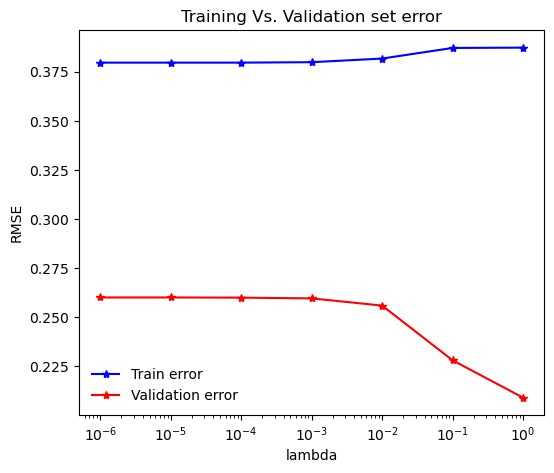

In [100]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

reg_lr_ws_var_lambda = [reg_lr_ws_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[0])]
rmse_validation = reg_lr_rmse[:,opt_col]

rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, reg_lr_ws_var_lambda, penalty, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, penalty, 'lambda')

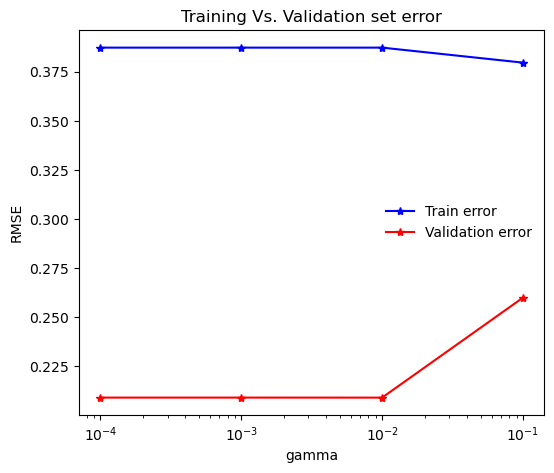

In [101]:
# Training (balanced) Vs. Validation error
fig, ax = plt.subplots(figsize = (6,5))

reg_lr_ws_var_gamma = [reg_lr_ws_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[1])]
rmse_validation = reg_lr_rmse[opt_row, :]

rmse_training = train_vs_valid(tx_training_balanced, y_training_balanced, reg_lr_ws_var_gamma, learning_rate, False)
plot_train_test(ax, "Training Vs. Validation set error", rmse_training, rmse_validation, learning_rate, 'gamma')

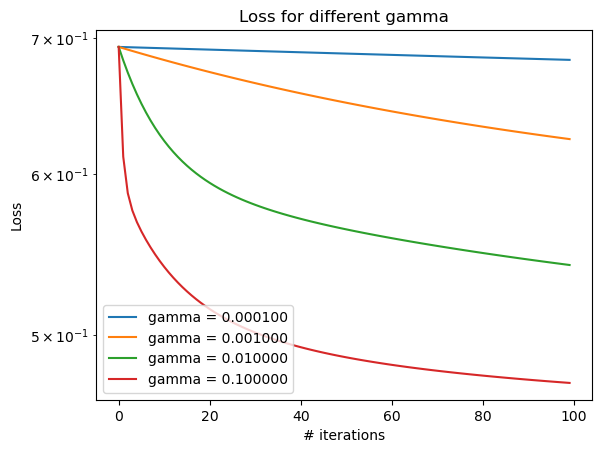

In [102]:
# Visualization
reg_lr_losses_var_gamma =  [reg_lr_losses_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[1])]
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

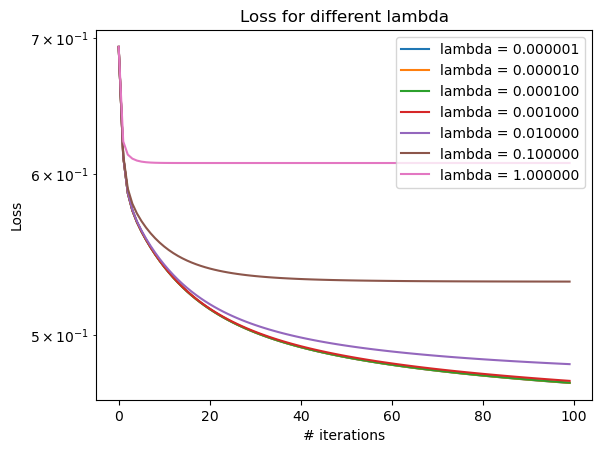

In [103]:
# Visualization
reg_lr_losses_var_lambda = [reg_lr_losses_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[0])]
plot_loss_variable_param(reg_lr_losses_var_lambda, penalty, 'lambda')

In [104]:
# Identify features with the strongest correlation to the target variable
highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_weights_cat, highest_correlated_cont_feat, highest_weights_cont = highly_correlated_features(opt_w.flatten(), feature_cat_map, feature_cat_encoded_map, feature_cont_map, categorical_features, continuous_features, 10, 1)
print('The categorical and continuous features with higher weights are respectively \n{} - columns {} \nand \n{}.'.format(highest_correlated_cat_feat, highest_correlated_cat_encoded_feat, highest_correlated_cont_feat))
print('The correspondend weights are respectively \n{}\nand \n{}.'.format(highest_weights_cat, highest_weights_cont))

The categorical and continuous features with higher weights are respectively 
['HIVTST6' '_PASTAE1' 'EXERANY2' '_TOTINDA' '_PAREC1' '_LTASTH1'
 '_BMI5CAT' '_RFBMI5' 'INTERNET' '_RFHYPE5'] - columns [2 2 2 2 4 2 4 2 2 2] 
and 
['BEANDAY_'].
The correspondend weights are respectively 
[0.04855162 0.04969448 0.05257281 0.05257281 0.05467148 0.07232443
 0.08696374 0.08782704 0.16446049 0.38746175]
and 
[0.00348122].


Regularization Effects: If you apply regularization during training, the model will be less flexible on the training data, potentially leading to higher training error. However, regularization often improves generalization on new data, leading to lower validation error.

Data Sampling Variability: Sometimes, by chance, the validation set may contain data points that the model is better suited to predict compared to some outliers or noisy samples in the training set. This sampling variability can cause the validation error to be slightly lower.

Purpose: Cross-validation helps evaluate how the model generalizes to unseen data, providing insights into both bias and variance.
Interpretation: Consistent performance across different folds indicates low variance, while significant fluctuations suggest high variance.

Calculating the MSE on both training and validation datasets provides a quantitative measure of bias and variance.
Interpretation:
High training MSE with low validation MSE indicates high bias.
Low training MSE with high validation MSE indicates high variance.